In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [37]:
# Step 1: Data Preparation
# Aggregate transaction data for customer behavior
customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    transaction_count=('TransactionID', 'count')
).reset_index()

In [38]:
# Merge with customer data for a full profile
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left').fillna(0)

In [39]:
# Encode categorical data (Region)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [40]:
# Select features for clustering
features = ['total_spent', 'total_quantity', 'transaction_count'] + [col for col in customer_data.columns if 'Region_' in col]


In [41]:
# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features])

In [47]:
# Step 2: Clustering
# Define the range for the number of clusters
clusters_range = range(2, 11)
db_index_values = []
kmeans_models = []

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)

    db_index_values.append(db_index)
    kmeans_models.append((n_clusters, kmeans, cluster_labels))


In [48]:
# Find the optimal number of clusters with the lowest DB Index
optimal_idx = np.argmin(db_index_values)
optimal_clusters = kmeans_models[optimal_idx]
optimal_n_clusters, optimal_kmeans, optimal_labels = optimal_clusters

In [49]:
# Assign cluster labels to customer data
customer_data['Cluster'] = optimal_labels

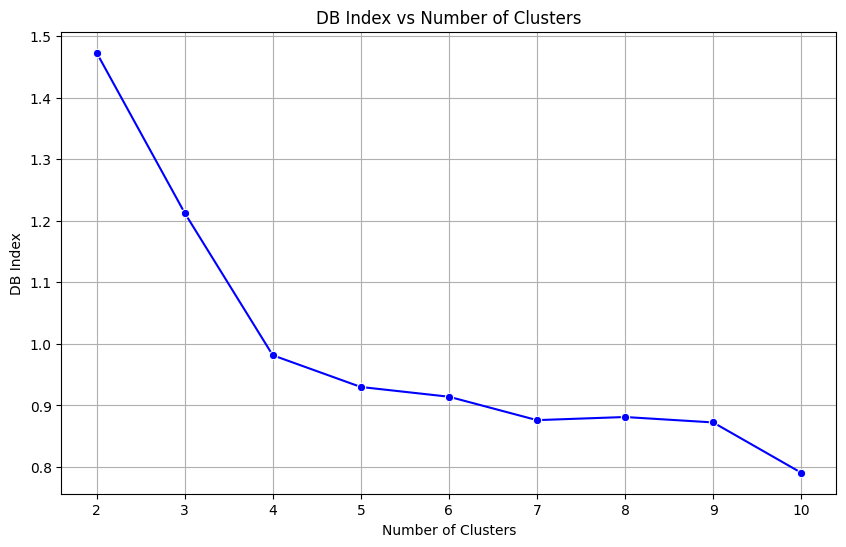

In [50]:
# Step 3: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(clusters_range), y=db_index_values, marker='o', color='blue')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid(True)
plt.show()

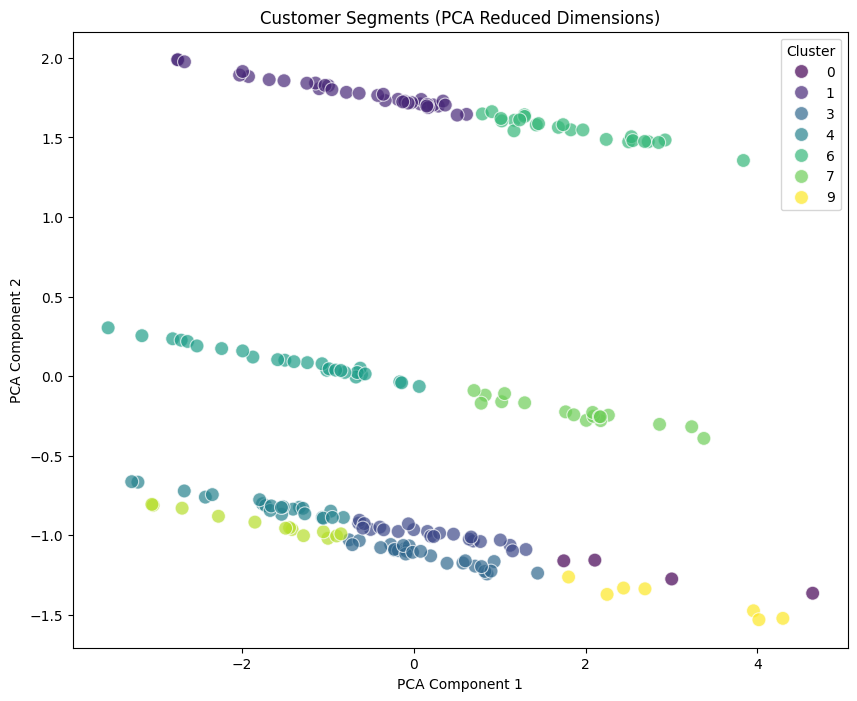

In [51]:
# Visualize clusters in 2D (PCA for dimensionality reduction)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1],
    hue=customer_data['Cluster'], palette='viridis', s=100, alpha=0.7
)
plt.title('Customer Segments (PCA Reduced Dimensions)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [52]:
# Step 4: Save Results
customer_data.to_csv('Customer_Segments.csv', index=False)

In [53]:
# Report metrics
print(f'Optimal Number of Clusters: {optimal_n_clusters}')
print(f'Davies-Bouldin Index for Optimal Clusters: {db_index_values[optimal_idx]}')

Optimal Number of Clusters: 10
Davies-Bouldin Index for Optimal Clusters: 0.790706369296275
